In [26]:
library(ggplot2)
library(gridExtra)
library(grid)
library(matrixStats)
library(fda)

# Load data

Set up the folders that contains data.

In [27]:
c_folder_name = 'NIH/Emotion'
q_folder_name = 'NIH'

Load questionnaires, connectome  and variance explained data.

In [28]:
c = read.table(paste('Data/Connectome/', c_folder_name, '/Adjust/c_adj.csv', sep = ''), sep = ',', header = TRUE, row.names = 1)

In [29]:
q = read.table(paste('Data/Questionnaire/', q_folder_name, '/Adjust/q_adj.csv', sep = ''), sep = ',', header = TRUE, row.names = 1)
q = q[rownames(c),]

Pick only negative questionnaires.

In [30]:
q = q[,1:6]
colnames(q)

[1] "AngAffect_Unadj"  "AngHostil_Unadj"  "AngAggr_Unadj"    "FearAffect_Unadj"
[5] "FearSomat_Unadj"  "Sadness_Unadj"

Load group labels.

In [31]:
groups = unlist(read.table('Data/Connectome/region_to_region.csv', sep = ',', header = FALSE))

# Cross-Validated Group RCCA
Splits the data in train (80%) and test (20%) at random and returns the canonical correlations for training and test data.
Calculate 1SD confidence intervals for train and test canonical correlations.

In [32]:
GRCCA_CV = function(X, Y, lambda1s, nus, groups, nreps = 100){
    ncomp = ncol(Y)
    n = nrow(X)
    colnames(X) = groups
    cor_cv = c()
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]  
    for(nu in nus){
        #create extended matrix
        Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale = sqrt(nu/ngs[group_names])), X - Xmean[,groups])
        #compute R and V for extended matrix
        SVD = svd(Xextended)
        R = SVD$u %*% diag(SVD$d)
        V = SVD$v
        rownames(V) = colnames(Xextended)
        for(lambda1 in lambda1s){
            cor_train = matrix(0, ncomp, nreps)
            cor_test = matrix(0, ncomp, nreps)
            colnames(cor_train) = paste('seed', 1:nreps, sep = '')
            colnames(cor_test) = paste('seed', 1:nreps, sep = '')
            #repeat split nreps times and save train and test correlations
            for(i in 1:nreps){
                set.seed(i)
                #split data into train and test
                ind_train = sample(n, size = round(n * 0.8))
                #run RCCA
                Crr = var(R[ind_train, ], na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
                Cyy = var(Y[ind_train, ], na.rm = TRUE, use = "pairwise")
                Cry = cov(R[ind_train, ], Y[ind_train, ], use = "pairwise")
                RCCA = geigen(Cry, Crr, Cyy)
                names(RCCA) = c("cor", "xcoef", "ycoef")
                #transform alpha to Xextended basis
                RCCA$xcoef = V %*% RCCA$xcoef
                #transform alpha to X basis
                alphaXmean = RCCA$xcoef[1:ncol(Xmean),]
                alphaXmean = t(scale(t(alphaXmean), center = FALSE, scale = sqrt(ngs[rownames(alphaXmean)] * nu)))
                alphaX = RCCA$xcoef[-(1:ncol(Xmean)),]
                alpha = alphaX + alphaXmean[groups,]
                beta = RCCA$ycoef
                #compute train and test correlation
                cor_train[,i] = RCCA$cor
                cor_test[,i] = diag(cor(X[-ind_train, ]%*%alpha, Y[-ind_train, ]%*%beta))
            }
            cor_cv = rbind(cor_cv, data.frame(cor_train, 'comp' = 1:ncomp, 'set' = 'train', 'lambda1' = lambda1, 'nu' = nu), 
                             data.frame(cor_test, 'comp' = 1:ncomp, 'set' = 'test', 'lambda1' = lambda1, 'nu' = nu))
        }
    }
    return(cor_cv)
}

# Run grid search for GRCCA

Vary $\lambda_1$ and $\nu$ and compute GRCCA.

In [33]:
nus = 10^seq(-5,7)
lambda1s = 10^seq(-2,4)
nreps = 100

cor_cv = GRCCA_CV(as.matrix(c), as.matrix(q), lambda1s, nus, groups, nreps)
write.csv(cor_cv, file = paste('Data/Connectome/', c_folder_name, '/GRCCA/grcca_cor.csv', sep = ''), row.names = FALSE)

Plot GRCCA results for different values of $\lambda_1$ and $\nu$.

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (s

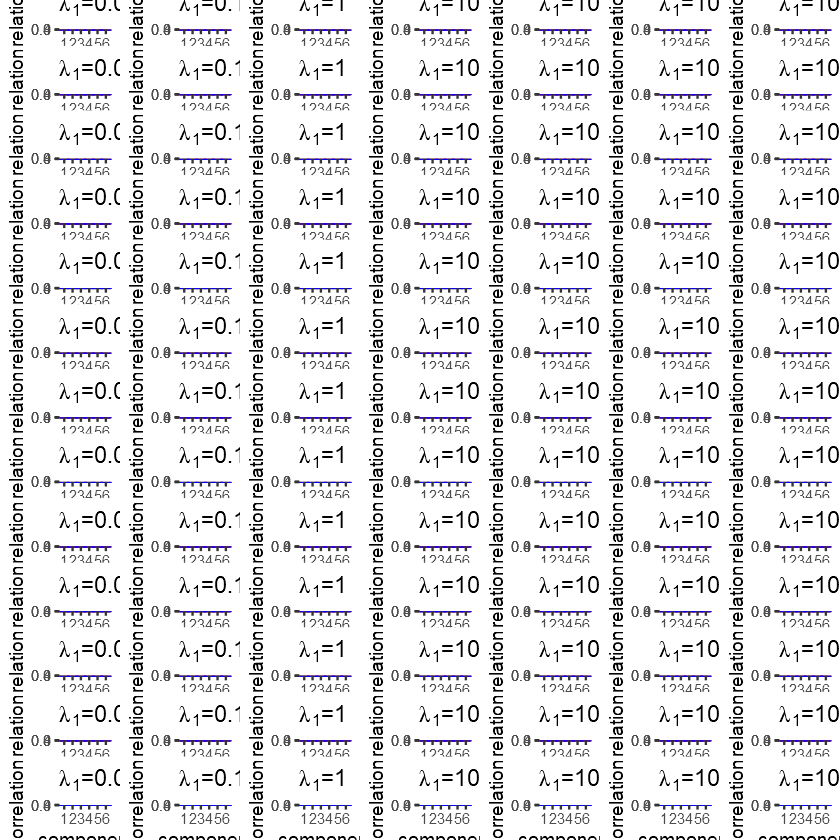

In [34]:
cor_plots = list()
ncomp = ncol(q)
i = 1

for(r in nus){
    for(lam1 in lambda1s){
        cor_train = data.frame(t(subset(cor_cv, lambda1 == lam1 & nu == r & set == 'train')[, 1:nreps]))
        colnames(cor_train) = 1:ncomp
        cor_test = data.frame(t(subset(cor_cv, lambda1 == lam1 & nu == r & set == 'test')[, 1:nreps]))
        colnames(cor_test) = 1:ncomp     
        cor_plots[[i]] = ggplot() +
            geom_hline(yintercept = 0, color = 'darkgreen') +
            geom_boxplot(stack(cor_train), mapping = aes(x = ind, y = values), outlier.alpha = 0, fatten = 0, fill = 'white')+
            geom_boxplot(stack(cor_test), mapping = aes(x = ind, y = values), outlier.alpha = 0, fatten = 0, fill = 'white')+
            geom_point(data.frame('x' = 1:ncomp, 'y' = colMeans(cor_train)), mapping = aes(x, y), size = 2, shape = 23, color = 'red', fill = 'red') +
            geom_point(data.frame('x' = 1:ncomp, 'y' = colMeans(cor_test)), mapping = aes(x, y), size = 2, shape = 23, color = 'blue', fill = 'blue') +    
            ylim(-0.3, 1.1)+
            xlab('component') +
            ylab('correlation')+
            ggtitle(bquote(paste(lambda[1], '=', .(lam1), '   ', mu[1]/lambda[1], '=', .(r))))
        i = i + 1
    }
}
cor_plots = do.call("grid.arrange", c(cor_plots, nrow = length(nus)))
ggsave(file = paste('Data/Connectome/', c_folder_name, '/GRCCA/grcca_grid_search(boxplot).png', sep = ''), device = 'png', plot = cor_plots, width = 20, height = 40)

Search for the best $\lambda_1$ and $\nu$ with the highest value of the first test canonical correlation.

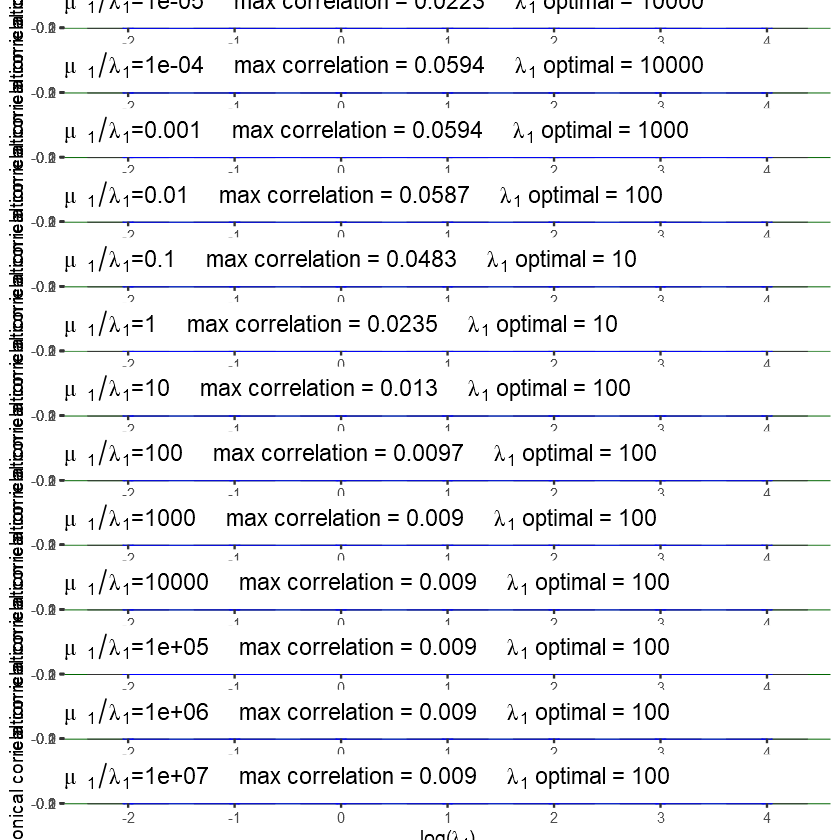

In [35]:
first_plots = list()
i = 1

for(r in nus){
    first = data.frame(t(subset(cor_cv, nu == r & set == 'test' & comp == 1)[,1:nreps]))
    colnames(first) = lambda1s
    center = colMeans(first)
    lambda_opt = lambda1s[which.max(center)]
    first_plots[[i]] = ggplot() +
        geom_hline(yintercept = 0, color = 'darkgreen') +
        geom_boxplot(stack(first), mapping = aes(x = as.factor(log(as.numeric(paste(ind)), 10)), y = values), outlier.alpha = 0, fatten = 0, fill = 'white')+
        geom_point(data.frame('lambda' = lambda1s, 'cor' = center), mapping = aes(x = as.factor(log(lambda, 10)), y = cor), size = 2, shape = 23, color = 'blue', fill = 'blue') +
        geom_line(data.frame('lambda' = lambda1s, 'cor' = center), mapping = aes(x = as.factor(log(lambda, 10)), y = cor), color = 'blue', group = 1) + 
        xlab(bquote(paste('log(', lambda[1], ')', sep = ''))) +
        ylab('first canonical correlation')+
        ggtitle(bquote(paste(mu[1]/lambda[1], '=', .(r), '     ', 'max correlation = ', .(round(max(center), 4)), '     ', lambda[1], ' optimal = ', .(lambda_opt), sep = ' ')))
        i = i + 1
}
first_plots = do.call("grid.arrange", c(first_plots, nrow = length(nus)))
ggsave(file = paste('Data/Connectome/', c_folder_name, '/GRCCA/grcca_best_lambda(boxplot).png', sep = ''), device = 'png', plot = first_plots, width = 6, height = 35)

# Calculate RCCA for the best lambda.

In [36]:
GRCCA = function(X, Y, lambda1, nu, groups){
    colnames(X) = groups
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]
    Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale =  sqrt(nu/ngs[group_names])), X - Xmean[,groups])
    SVD = svd(Xextended)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(Xextended)
    Cxx = var(R, na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
    Cyy = var(Y, na.rm = TRUE, use = "pairwise")
    Cxy = cov(R, Y, use = "pairwise")
    res = geigen(Cxy, Cxx, Cyy)
    names(res) = c("cor", "xcoef", "ycoef")
    res$xcoef = V %*% res$xcoef
    alpha0 = res$xcoef[1:ncol(Xmean),]
    alpha0 = t(scale(t(alpha0), center = FALSE, scale = sqrt(ngs[rownames(alpha0)] * nu) ))
    alpha = res$xcoef[-(1:ncol(Xmean)),]
    res$xcoef = alpha + alpha0[groups,]    
    return(list(cor = res$cor, xcoef = res$xcoef, ycoef = res$ycoef))
}

In [42]:
#Emotion
nu_opt = 10^(-4)
lambda1_opt = 10000
#Rest
#nu_opt = 10000
#lambda1_opt = 10 
#best = GRCCA(as.matrix(c), as.matrix(q), lambda1_opt, nu_opt, groups)

Save the loadings. 

In [43]:
alpha = best$xcoef 
colnames(alpha) = paste('GRCCA', 1:ncol(alpha), sep = '')
beta = best$ycoef
colnames(beta) = paste('GRCCA', 1:ncol(beta), sep = '')
write.csv(data.frame('c_pair' = colnames(c), alpha), file = paste('Data/Connectome/', c_folder_name, '/GRCCA/alpha.csv', sep = ''), row.names = FALSE)
write.csv(data.frame('q' = rownames(beta), beta), file = paste('Data/Connectome/', c_folder_name, '/GRCCA/beta.csv', sep = ''), row.names = FALSE)

Save scores.

In [44]:
brain_scores = as.matrix(c)%*%as.matrix(alpha)
write.csv(data.frame('Subject' = rownames(brain_scores), brain_scores), file = paste('Data/Connectome/', c_folder_name, '/GRCCA/brain_scores.csv', sep = ''), row.names = FALSE)
questionnaire_scores = as.matrix(q)%*%as.matrix(beta)
write.csv(data.frame('Subject' = rownames(questionnaire_scores), questionnaire_scores), file = paste('Data/Connectome/', c_folder_name, '/GRCCA/questionnaire_scores.csv', sep = ''), row.names = FALSE)

# Check mean and sd of coefficients

In [45]:
avg = aggregate(alpha, by = list(groups), FUN = mean)
rownames(avg) = avg[,1]
avg = avg[,-1]
quantile(avg[,1])

0%           25%           50%           75%          100% 
-2.251284e-07 -7.290710e-08 -3.841953e-08 -1.079119e-08  1.258757e-07

In [46]:
sds = aggregate(alpha, by = list(groups), FUN = sd)
rownames(sds) = sds[,1]
sds = sds[,-1]
quantile(sds[,1], na.rm = TRUE)

0%          25%          50%          75%         100% 
0.0001523441 0.0006955945 0.0008397087 0.0010380428 0.0017219000